In [1]:
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf

2023-04-05 17:05:18.217640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def relu(x):
    return max(0,x)

def swish(x) :
    return x * tf.nn.sigmoid(x)

def mish(x) :
    return x * tf.nn.tanh( tf.nn.softplus(x))

In [3]:
dijet = np.load("jj_nbm.npy",allow_pickle=True)
tttt = np.load("tttt_nbm.npy",allow_pickle=True)
ttbar = np.load("ttbar_nbm.npy",allow_pickle=True)
ttjj = np.load("ttjj_nbm.npy",allow_pickle=True)

In [30]:
np.identity((32))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
#data augmentation
def augmentation(images,repeat):
    copy = np.repeat(images, repeats=repeat)
    noise = np.random.uniform(copy.shape)
    


In [3]:
dijet_lab = []
tttt_lab = []
ttbar_lab = []
ttjj_lab = []
for ii in range(len(tttt)):
    tttt_lab.append([1,0,0,0])

for ii in range(len(dijet)):
    dijet_lab.append([0,1,0,0])

for ii in range(len(ttbar)):
    ttbar_lab.append([0,0,1,0])

for ii in range(len(ttjj)):
    ttjj_lab.append([0,0,0,1])
    
dijet_label = np.array(dijet_lab)
tttt_label = np.array(tttt_lab)
ttbar_label = np.array(ttbar_lab)
ttjj_label = np.array(ttjj_lab)

In [4]:
X = np.concatenate((dijet,tttt,ttbar,ttjj),axis=0)


In [5]:
Y = np.concatenate((dijet_label,tttt_label,ttbar_label,ttjj_label),axis=0)

In [6]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, Y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest)


In [7]:
categories = ["tttt","dijet","ttbar","ttjj"]
nb_classes = len(categories)

In [9]:
image_w = 32 
image_h = 32

In [10]:
 X_train = X_train.astype("float") / 256
X_test  = X_test.astype("float")  / 256
X_val = X_val.astype("float")  / 256

In [11]:
X_train_ts=X_train.transpose((0,2,3,1))[:,:,:,0]
X_val_ts=X_val.transpose((0,2,3,1))[:,:,:,0]

In [310]:
regul=tf.keras.regularizers.l2(0.7)


In [311]:
model = Sequential()
model.add(Convolution2D(32, 2, 2, 
    input_shape=(32,32,1),kernel_regularizer=regul))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(1, 1), padding='valid'))
model.add(Dropout(0.25))



model.add(Convolution2D(64, 3, 3, kernel_regularizer=regul))
model.add(Activation('elu'))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(1, 1), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten()) # --- (※3) 
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])



In [312]:
es = EarlyStopping(monitor='val_loss', mode='auto',restore_best_weights=True)

In [313]:
history = model.fit(X_train_ts, y_train, batch_size=32, epochs=50, validation_data = (X_val_ts,y_val), callbacks=es)

#history = model.fit(X_train_ts, y_train, batch_size=32, epochs=7, validation_data = (X_val_ts,y_val))


Epoch 1/50
9375/9375 [==============================] - 73s 8ms/step - loss: 0.4405 - accuracy: 0.6884 - val_loss: 0.3179 - val_accuracy: 0.7549
Epoch 2/50
9375/9375 [==============================] - 74s 8ms/step - loss: 0.3456 - accuracy: 0.7145 - val_loss: 0.3122 - val_accuracy: 0.7459
Epoch 3/50
9375/9375 [==============================] - 81s 9ms/step - loss: 0.3367 - accuracy: 0.7214 - val_loss: 0.3133 - val_accuracy: 0.7457


In [314]:
import matplotlib.pyplot as plt

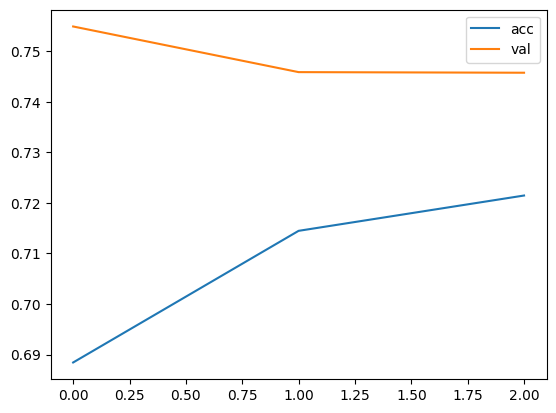

In [315]:
plt.plot(history.history["accuracy"], label = "acc")
plt.plot(history.history["val_accuracy"], label = "val")
plt.legend()


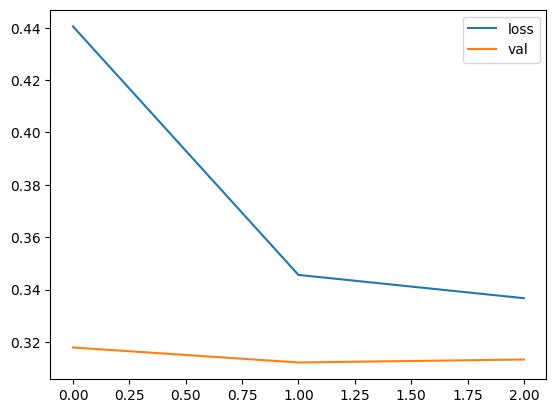

In [316]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val")
plt.legend()

In [317]:
history.history

{'loss': [0.44048011302948, 0.3456035554409027, 0.33671560883522034],
 'accuracy': [0.6884333491325378, 0.7144666910171509, 0.7214499711990356],
 'val_loss': [0.31789207458496094, 0.31216961145401, 0.31330353021621704],
 'val_accuracy': [0.7548800110816956, 0.7458533048629761, 0.7457333207130432]}

In [318]:
X_test_ts=X_test.transpose((0,2,3,1))[:,:,:,0]

In [319]:
y_pre = model.predict(X_test_ts)

782/782 [==============================] - 2s 2ms/step


In [320]:
import matplotlib.pyplot as plt

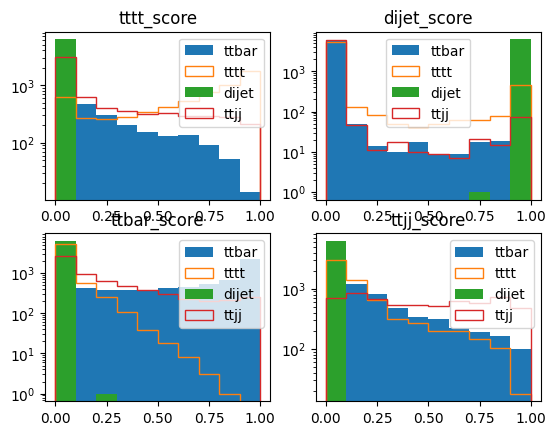

<Figure size 600x3000 with 0 Axes>

In [321]:
plt.subplot(2,2,1)

plt.hist(y_pre[:,0][y_test[:,2] == 1], bins=10, label = "ttbar", range = (0,1))
plt.hist(y_pre[:,0][y_test[:,0] == 1], bins=10, histtype = 'step',label="tttt", range = (0,1))
plt.hist(y_pre[:,0][y_test[:,1] == 1], bins=10, label = "dijet", range = (0,1))
plt.hist(y_pre[:,0][y_test[:,3] == 1], bins=10, label = "ttjj", histtype = "step", range = (0,1))


plt.title("tttt_score")
plt.yscale("log")
plt.legend()


plt.subplot(2,2,2)

plt.hist(y_pre[:,1][y_test[:,2] == 1], bins=10, label = "ttbar", range = (0,1))
plt.hist(y_pre[:,1][y_test[:,0] == 1], bins=10, histtype = 'step',label="tttt", range = (0,1))
plt.hist(y_pre[:,1][y_test[:,1] == 1], bins=10, label = "dijet", range = (0,1))
plt.hist(y_pre[:,1][y_test[:,3] == 1], bins=10, label = "ttjj", histtype = "step", range = (0,1))

plt.title("dijet_score")
plt.yscale("log")
plt.legend()

plt.subplot(2,2,3)


plt.hist(y_pre[:,2][y_test[:,2] == 1], bins=10, label = "ttbar", range = (0,1))
plt.hist(y_pre[:,2][y_test[:,0] == 1], bins=10, histtype = 'step',label="tttt", range = (0,1))
plt.hist(y_pre[:,2][y_test[:,1] == 1], bins=10, label = "dijet", range = (0,1))
plt.hist(y_pre[:,2][y_test[:,3] == 1], bins=10, label = "ttjj", histtype = "step", range = (0,1))

plt.title("ttbar_score")
plt.yscale("log")
plt.legend()

plt.subplot(2,2,4)


plt.hist(y_pre[:,3][y_test[:,2] == 1], bins=10, label = "ttbar", range = (0,1))
plt.hist(y_pre[:,3][y_test[:,0] == 1], bins=10, histtype = 'step',label="tttt", range = (0,1))
plt.hist(y_pre[:,3][y_test[:,1] == 1], bins=10, label = "dijet", range = (0,1))
plt.hist(y_pre[:,3][y_test[:,3] == 1], bins=10, label = "ttjj", histtype = "step", range = (0,1))

plt.title("ttjj_score")
plt.yscale("log")
plt.legend()

plt.figure(figsize=(6,30))
plt.show()

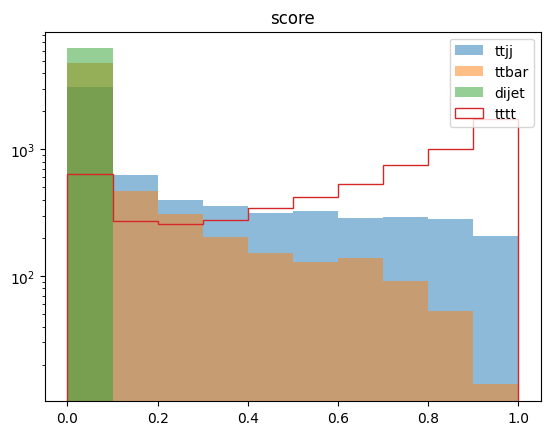

In [322]:
plt.hist(y_pre[:,0][y_test[:,3] == 1], bins=10, label = "ttjj", range = (0,1), alpha = 0.5)

plt.hist(y_pre[:,0][y_test[:,2] == 1], bins=10, label = "ttbar", range = (0,1), alpha = 0.5)
plt.hist(y_pre[:,0][y_test[:,1] == 1], bins=10, label = "dijet", range = (0,1), alpha = 0.5)

plt.hist(y_pre[:,0][y_test[:,0] == 1], bins=10, histtype = 'step',label="tttt", range = (0,1))


plt.title("score")
plt.yscale("log")
plt.legend()
plt.show()